In [2]:


## include libraries 

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import os.path, sys

from astropy.time import Time
from scipy import signal

## -----------------------------------

## set variables 
year= 2019
doy = 220 # good example: 222 2019 # bad example: 100 2019


## set path to find the data log files
path='/import/freenas-ffb-01-data/romy_status/'

outpathfigs = '/home/brotzer/notebooks/figs'


## assign parameters of *mjd file
Uref ='p2'
AC   ='p3'
Freq ='p4'
DC   ='p5'

## assign rings 
rings={'Z':0, 'U':2, 'V':1, 'W':3}
#rings={'Z':0,'U':1}
#rings={'Z':0}


#plt.style.use('seaborn')

In [3]:
## check availability of file and load if available 
def check_availablity(year,doy):
    file=[]
    for jj in [1,2,3,4]:
        if os.path.exists(path+'beagle0{}-romy/romy-0{}_{}_{}.mjd'.format(jj,jj,year,doy)):
            file.append('beagle0{}-romy/romy-0{}_{}_{}.mjd'.format(jj,jj,year,doy))
        else: 
            print('beagle0{}-romy/romy-0{}_{}_{}.mjd   FILE NOT FOUND !'.format(jj,jj,year,doy))
    
    return file

In [4]:
## method to retrieve data from log-file and store it as dataframe 
def get_data(path,file):
    '''
    dependencies:  
        import pandas as pd 
        from astropy.time import Time
    '''
    
    ## try to find and read mjd-files of ROMY
    try:
        df=pd.read_csv(path+file,delimiter='\t',names=['mjd','p1','p2','p3','p4','p5'])

    except:
        print('\n!!! ERROR IMPORTING!!! \n-->Possibliy file does not exist?!\n{}\n'.format(path+file))
    
    ## print file name 
    print('\n {} \n'.format(file))    
    
    ## print begin and end of timeline from mjd
    tmjd=Time(df['mjd'], format='mjd', scale='tt')
    print('from {} to {} \n'.format(tmjd[0].iso,tmjd[len(df['mjd'])-1].iso))
     
    ## calculate time in seconds
    seconds=[]
    for tt in np.array(tmjd.iso):
        seconds.append(int(tt[11:13])*3600+int(tt[14:16])*60+int(tt[17:19])+float(tt[20:23]))
    
    ## add time in seconds to dataframe
    df.insert(1, "time", seconds, True) 
        
    
    ## print top of file 
    print(df.head())
    print(df.tail())
    
    ## print number of rows
    rows,cols=df.shape
    print('\n number of rows: {} \n number of columns: {} \n'.format(rows,cols))


    return df

In [5]:
def makeplot_monitor(path,file,index,rings):
    
    ## get the data for one component        
    data=get_data(path,file[index]); print('________________________________________________________')
    
    freq0 = [551.677,448.092,302.959,448.092]

    sub_data=data[(data[Freq] > (freq0[index]-50)) & (data[Freq] < (freq0[index]+50))]
    print(sub_data[Freq].count())
    

    
    maxindex=len(rings)-1
    
    if index == 0:
        fig.subplots_adjust(wspace=0.4)
        
        ## adjust axes
#        axes[maxindex,0].set_xlim(0,86400)

#        axes[maxindex,0].set_xticks(np.linspace(0,86400,25))
#        axes[maxindex,0].set_xticklabels([ind if ind%2==0 else '' for ind in np.arange(0,25,1)])
        
        ## add labels for shared x-axes 
        axes[maxindex,0].set_xlabel('Time (hr)')
        axes[maxindex,1].set_xlabel('Time (hr)')
        axes[maxindex,3].set_xlabel('Time (hr)')
        axes[maxindex,4].set_xlabel('Frequency (Hz)')

        ## add titles for the RINGs
        for ring in rings:
            pos = axes[rings[ring],0].get_position()
            axes[rings[ring],0].text(pos.x0-0.5,(pos.y1-pos.y0)/2+0.2,'{}-RING'.format(ring),fontsize=15,rotation=90, ha='center',\
                           transform=axes[rings[ring],0].transAxes); del pos


        ## add plot title
        pos = axes[0,0].get_position()
        date_and_time=Time(data['mjd'][0], format='mjd', scale='tt')
        axes[0,0].text(pos.x0, pos.y1+3,'ROMY -- Parameter Monitoring:  {}  (DoY: {})'.format(date_and_time.iso[0:10],doy), \
                       fontsize=16, ha='left'); del pos
        
        
  

    
    ## _______________________________________________________________________________________________________   
    ## ___Col 0____________________
        
        
    ## plot AC data
    l1=axes[index,0].scatter(data['time'],data[AC],label='AC',s=0.1,marker='.')
    
    ## plot DC data
    l2=axes[index,0].scatter(data['time'],data[DC],label='DC',s=0.1,marker='.')
    
    ## plot parameter p5
    l3=axes[index,0].scatter(data['time'],data[Uref],label=r'U$_{ref}$',s=0.1,marker='.')
    
    ## label first y-axis before introducing the second
    axes[index,0].set_ylabel('Amp (V)')
    axes[index,0].set_ylim(0,3)


    ## add combined legend 
    if index == maxindex:
        pos=axes[maxindex,0].get_position()
        lns = [l1,l2,l3] ;   labs = [l.get_label() for l in lns]
        axes[index,0].legend(lns,labs,loc='lower center',bbox_to_anchor=(0.5,-0.7),markerscale=16,shadow=True,ncol=3)


    axes[index,0].set_xticks(np.linspace(0,86400,25))
    axes[index,0].set_xticklabels([ind if ind%4==0 else '' for ind in np.arange(0,25,1)])
 
    
 
    ## _______________________________________________________________________________________________________
    ## ___COL 1____________________


    axes[index,1].scatter(data['time'],data[Uref],label=r'U$_{ref}$',s=0.1,marker='.',color='green')

    a, b = np.polyfit(data['time'],data[Uref],1)
    axes[index,1].plot(data['time'],a*data['time']+b,label=r'U$_{ref}$',color='orange')

    

    axes[index,1].set_ylim(data[Uref].median()-data[Uref].std()*3,data[Uref].median()+data[Uref].std()*3)
    
    axes[index,1].set_xticks(np.linspace(0,86400,25))
    axes[index,1].set_xticklabels([ind if ind%8==0 else '' for ind in np.arange(0,25,1)])
    axes[index,1].set_ylabel('U$_{ref}$ (V)')
 

    
    ## _______________________________________________________________________________________________________
    ## ___COL 2____________________
   
    dx=0.01
    
    nums = int(max(sub_data[Uref]-min(sub_data[Uref]))/dx)
    
    bins = axes[index,2].hist(sub_data[Uref],bins=nums,width=dx/2,color='g')   

    axes[index,2].set_xlim(min(sub_data[Uref]),max(sub_data[Uref]))

    
    ## _______________________________________________________________________________________________________
    ## ___COL 3____________________


    div=1/4

    axes[index,3].scatter(sub_data['time'],sub_data[Freq],label='freq',s=0.001,marker='.',color='r')

    axes[index,3].plot(sub_data['time'],np.ones(len(sub_data['time']))*freq0[index],linewidth=1,linestyle='--',color='grey')
    

    ## adjust y-axis
    axes[index,3].set_ylabel('Frequency (Hz)')
    axes[index,3].set_ylim(sub_data[Freq].median()-sub_data[Freq].std()/div,sub_data[Freq].median()+sub_data[Freq].std()/div)
#    axes[index,2].set_ylim(freq0[index]-5,freq0[index]+5)


    axes[index,3].set_xticks(np.linspace(0,86400,25))
    axes[index,3].set_xticklabels([ind if ind%4==0 else '' for ind in np.arange(0,25,1)])
     

 
    
    ## _______________________________________________________________________________________________________
    ## ___COL 4____________________

      
    div=1/10
    dx=0.01
    
    num = int(((freq0[index]+sub_data[Freq].std()/div)-(freq0[index]-sub_data[Freq].std()/div)) /dx)
    if num < 50:
        num=50
        
    
    bins = axes[index,4].hist(sub_data[Freq],bins=num,width=dx/2,log=True,color='r',range=(round(freq0[index]-sub_data[Freq].std()/div), round(freq0[index]+sub_data[Freq].std()/div)))
#    bins = axes[index,3].hist(sub_data[Uref],bins=200,width=0.1,color='g')   
    axes[index,4].plot([freq0[index],freq0[index]],[0,86400],'--',color='grey',linewidth=1)
    
#    axes[index,2].set_yscale('log')
    
    
    binsnotzero = [i for i,j in zip(bins[1],bins[0]) if j > 0]
    binsnotzero.append(freq0[index])
    xmin = min(binsnotzero)    
    xmax = max(binsnotzero)
    
    axes[index,4].set_xlim(xmin-0.5,xmax+0.5)
#    axes[index,2].set_ylim(0,86400)
    
    axes[index,4].set_ylabel('Counts')
    axes[index,4].set_yticks([1e1,1e3,1e5])
    # labels = [str(j) for i,j in enumerate(axes[index,2].get_yticklabels()) if i%2==0]
    # print(labels)
    # axes[index,3].set_yticklabels(labels)



    del  data, sub_data


 beagle01-romy/romy-01_2019_220.mjd 

from 2019-08-08 00:00:00.000 to 2019-08-08 09:29:04.000 

            mjd  time  p1    p2    p3      p4    p5
0  58703.000000   0.0  40  0.97  0.81  552.95  1.17
1  58703.000012   1.0  40  0.97  0.81  552.90  1.18
2  58703.000023   2.0  40  0.99  0.81  552.90  1.17
3  58703.000035   3.0  40  0.97  0.81  552.95  1.17
4  58703.000046   4.0  40  0.97  0.81  553.72  1.17
                mjd     time  p1    p2    p3      p4    p5
34140  58703.395139  34140.0  40  0.97  0.80  552.90  1.16
34141  58703.395150  34141.0  40  0.97  0.81  552.90  1.16
34142  58703.395162  34142.0  40  0.98  0.80  552.95  1.16
34143  58703.395174  34143.0  40  0.97  0.80  552.90  1.15
34144  58703.395185  34144.0  40  0.97  0.80  553.72  1.16

 number of rows: 34145 
 number of columns: 7 

________________________________________________________
34103

 beagle02-romy/romy-02_2019_220.mjd 

from 2019-08-08 12:30:29.000 to 2019-08-08 23:59:59.000 

            mjd     time  p1

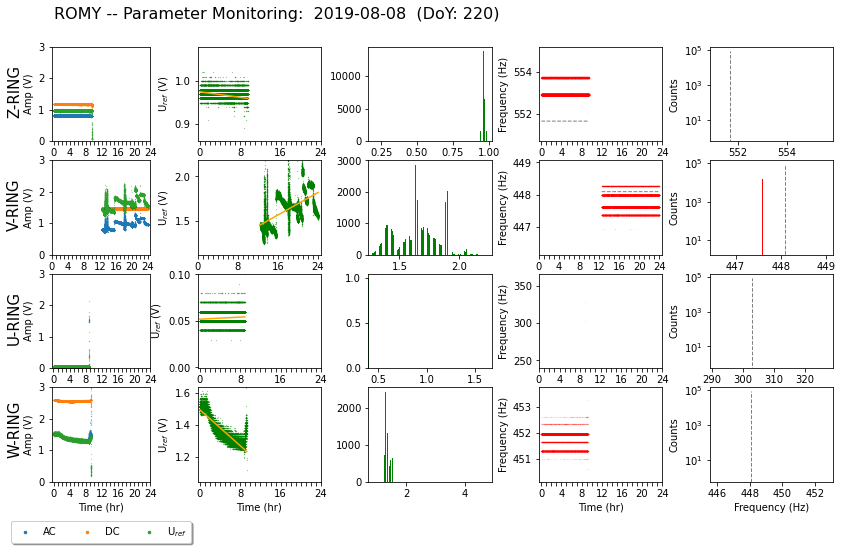

In [11]:
## check if files exists and form array
file=check_availablity(year,doy)

maxima=[]


## create plot with subplots dynamically according to rings dictionary 
fig, axes = plt.subplots(len(rings),5,figsize=(14,len(rings)*2),sharex=False, gridspec_kw={'width_ratios': [2,2.5,2.5,2.5,2.5],'height_ratios': np.ones(len(rings))})


## subsequently fill rows of plot 
for index in range(len(rings)):

    makeplot_monitor(path,file,index,rings)    




## ------------

## save file into ~/spyder/figs folder
plt.savefig('{}/beagle_romy_{}_{}'.format(outpathfigs,year,doy), dpi=300, facecolor='w', papertype='A4', format=None)


plt.show();


 beagle02-romy/romy-02_2019_220.mjd 

from 2019-08-08 12:30:29.000 to 2019-08-08 23:59:59.000 

            mjd     time  p1    p2    p3     p4    p5
0  58703.521169  45029.0  40  1.45  0.83  447.6  1.48
1  58703.521181  45030.0  40  1.48  0.81  447.6  1.47
2  58703.521192  45031.0  40  1.46  0.81  447.6  1.47
3  58703.521204  45032.0  40  1.44  0.82  447.6  1.52
4  58703.521215  45033.0  40  1.44  0.82  447.6  1.52
                mjd     time  p1    p2    p3     p4    p5
41366  58703.999942  86395.0  40  1.55  0.96  447.6  1.47
41367  58703.999954  86396.0  40  1.55  0.95  448.0  1.47
41368  58703.999965  86397.0  40  1.53  0.96  448.0  1.47
41369  58703.999977  86398.0  40  1.56  0.96  448.0  1.47
41370  58703.999988  86399.0  40  1.57  0.96  448.0  1.46

 number of rows: 41371 
 number of columns: 7 

________________________________________________________
0        447.6
1        447.6
2        447.6
3        447.6
4        447.6
         ...  
41366    447.6
41367    448.0
41368

(445.9251700680272, 449.64852607709753)

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'Counts')

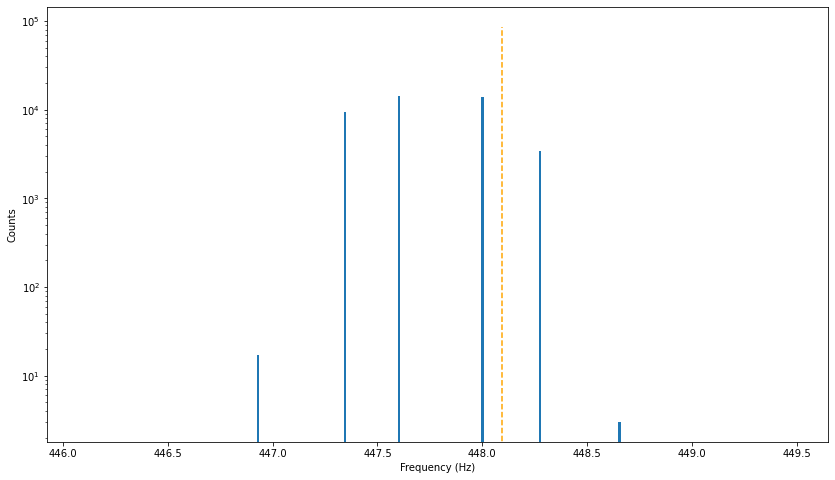

In [13]:

freq0 = [551.677,448.092,302.959,448.092]

comp=1

data=get_data(path,file[comp]); print('________________________________________________________')

print(data[Freq])

sub_data=data[(data[Freq] > (freq0[comp]-50)) & (data[Freq] < (freq0[comp]+50))]

if sub_data[Freq].count() < 3600:
    print('\nexiting !!! \n')
    sys.exit()

fig, ax = plt.subplots(1,1,figsize=(14,8),sharex=False)

div=1/6; num = int(((freq0[comp]+sub_data[Freq].std()/div)-(freq0[comp]-sub_data[Freq].std()/div)) / 0.01)
if num < 50:
    num=50
    

bins = ax.hist(sub_data[Freq],bins=num,log=True,width=0.01,range=(round(freq0[comp]-sub_data[Freq].std()/div), round(freq0[comp]+sub_data[Freq].std()/div)))

ax.plot([freq0[comp],freq0[comp]],[0,86400],color='orange',linestyle='--')


binsnotzero = [i for i,j in zip(bins[1],bins[0]) if j > 0]
binsnotzero.append(freq0[comp])
xmin = min(binsnotzero)    
xmax = max(binsnotzero)

ax.set_xlim(xmin-1,xmax+1)

ax.set_xlabel('Frequency (Hz)',fontsize=10)
ax.set_ylabel('Counts',fontsize=10)


 beagle02-romy/romy-02_2019_220.mjd 

from 2019-08-08 12:30:29.000 to 2019-08-08 23:59:59.000 

            mjd     time  p1    p2    p3     p4    p5
0  58703.521169  45029.0  40  1.45  0.83  447.6  1.48
1  58703.521181  45030.0  40  1.48  0.81  447.6  1.47
2  58703.521192  45031.0  40  1.46  0.81  447.6  1.47
3  58703.521204  45032.0  40  1.44  0.82  447.6  1.52
4  58703.521215  45033.0  40  1.44  0.82  447.6  1.52
                mjd     time  p1    p2    p3     p4    p5
41366  58703.999942  86395.0  40  1.55  0.96  447.6  1.47
41367  58703.999954  86396.0  40  1.55  0.95  448.0  1.47
41368  58703.999965  86397.0  40  1.53  0.96  448.0  1.47
41369  58703.999977  86398.0  40  1.56  0.96  448.0  1.47
41370  58703.999988  86399.0  40  1.57  0.96  448.0  1.46

 number of rows: 41371 
 number of columns: 7 

________________________________________________________


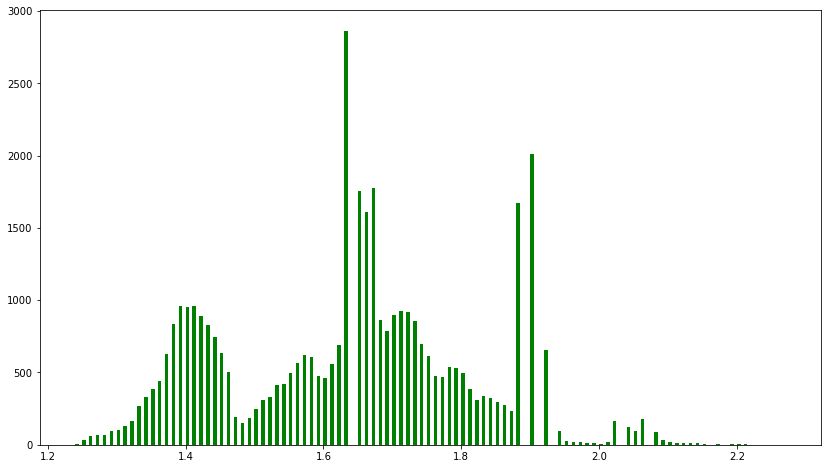

In [19]:
comp=1

data=get_data(path,file[comp]); print('________________________________________________________')

sub_data=data[(data[Freq] > (freq0[comp]-50)) & (data[Freq] < (freq0[comp]+50))]

if sub_data[Freq].count() < 3600:
    print('\n!!!exiting !!! Not enough Data (<3600s)! \n')
    sys.exit()

fig, ax = plt.subplots(1,1,figsize=(14,8),sharex=False)

dx=0.01
nums = int(max(sub_data[Uref]-min(sub_data[Uref]))/0.01)

bins = ax.hist(sub_data[Uref],bins=nums,width=dx/2,color='g')   

#%%
# End of File